In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from collections import OrderedDict

In [325]:
def addPadding(img, bs, gray):
    h, w = 0, 0
    if(gray == 0):
        h, w = img[:, :, 0].shape
    else:
        h, w = img.shape
        
    addRows = 0
    addCols = 0
    if(h % bs != 0):
        rem = h % bs
        addRows = bs - rem
    if(w % bs != 0):
        rem = w % bs
        addCols = bs - rem
        
    if(gray == 0):
        newImg = np.zeros((h + addRows, w + addCols, 3), dtype = np.float32)
        newImg[:h, :w, :] = img
        return newImg
    else:
        newImg = np.zeros((h + addRows, w + addCols), dtype = np.float32)
        newImg[:h, :w] = img
        return newImg

In [66]:
def subtract(img):
    img -= 128
    return img

In [67]:
def applyDCT(img, bs, gray):
    if(gray == 0):
        h, w = img[:, :, 0].shape
        for x in range(3):
            for i in range(0, h, bs):
                for j in range(0, w, bs):
                    arr8 = img[:, :, x][i : i + bs, j : j + bs]
                    arr8 = cv2.dct(arr8.astype(np.float32))
                    img[:, :, x][i : i + bs, j : j + bs] = arr8
    else:
        h, w = img.shape
        for i in range(0, h, bs):
            for j in range(0, w, bs):
                arr8 = img[i : i + bs, j : j + bs]
                arr8 = cv2.dct(arr8.astype(np.float32))
                img[i : i + bs, j : j + bs] = arr8
    return img

In [68]:
def quantization(img, bs, q_y, q_c, gray):    
    
    if(gray == 0):
        h, w = img[:, :, 0].shape
        for i in range(0, h, bs):
            for j in range(0, w, bs):
                arr8 = img[:, :, 0][i : i + bs, j : j + bs]
                arr8 = (arr8/q_y).round().astype(np.int32)
                img[:, :, 0][i : i + bs, j : j + bs] = arr8
        for x in range(1, 3):
            for i in range(0, h, bs):
                for j in range(0, w, bs):
                    arr8 = img[:, :, x][i : i + bs, j : j + bs]
                    arr8 = (arr8/q_c).round().astype(np.int32)
                    img[:, :, x][i : i + bs, j : j + bs] = arr8
    else:
        h, w = img.shape
        for i in range(0, h, bs):
            for j in range(0, w, bs):
                arr8 = img[i : i + bs, j : j + bs]
                arr8 = (arr8/q_y).round().astype(np.int32)
                img[i : i + bs, j : j + bs] = arr8
        
    return img

In [69]:
# n refers to block size here
def zig_zag(block, n, coeff):
    lst = []
    lst.append(block[0,0])
    i = 0
    j = 0
    flag = 1
    while(len(lst) != coeff):
        if(flag == 1):
            if(i - 1 < 0  or j + 1 == n):
                if(j + 1 == n):
                    i += 1
                else:
                    j += 1
                flag = 0
            else:
                i -= 1
                j += 1
            lst.append(block[i,j])
        else:
            if(j - 1 < 0 or i + 1 == n):
                if(i + 1 == n):
                    j += 1
                else:
                    i += 1
                flag = 1
            else:
                i += 1
                j -= 1
            lst.append(block[i,j])
    return lst

In [70]:
def generateEncoding(img, coeff, bs, gray):
    encoding = []
    
    if(gray == 0):
        h, w = img[:, :, 0].shape
        for x in range(3):
            lst = []
            for i in range(0, h, bs):
                for j in range(0, w, bs):
                    arr8 = img[:, :, x][i : i + bs, j : j + bs]
                    op = zig_zag(arr8, bs, coeff)
                    lst.append(op)
            encoding.append(lst)
    else:
        h, w = img.shape
        lst = []
        for i in range(0, h, bs):
            for j in range(0, w, bs):
                arr8 = img[i : i + bs, j : j + bs]
                op = zig_zag(arr8, bs, coeff)
                lst.append(op)
        encoding.append(lst)
    return encoding

## Generate JPEG encoding

In [98]:
def JPEGEncoder(filename, bs, coeff, gray):
    img = cv2.imread(filename)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #<-----
    
    if(len(img.shape) == 2 and gray == 0):
        print("Error: Image is not RGB")
        return
    
    if(len(img.shape) == 3 and gray == 1):
        print("Error: Image is not Grayscale")
        return
    
    q_y = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
               [12, 12, 14, 19, 26, 58, 60, 55],
               [14, 13, 16, 24, 40, 57, 69, 56],
               [14, 17, 22, 29, 51, 87, 80, 62],
               [18, 22, 37, 56, 68, 109, 103, 77],
               [24, 35, 55, 64, 81, 104, 113, 92],
               [49, 64, 78, 87, 103, 121, 120, 101],
               [72, 92, 95, 98, 112, 100, 103, 99]], 'uint8')

    q_c = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
                   [18, 21, 26, 66, 99, 99, 99, 99],
                   [24, 26, 56, 99, 99, 99, 99, 99],
                   [47, 66, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99]], 'uint8')
    
    # converting to YUV if not grayscale
    yuv_img = []
    if(gray == 0):
        yuv_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    else:
        yuv_img = img
    yuv_img = yuv_img.astype(np.float32)
    
    # Introducing padding if required
    yuv_img = addPadding(yuv_img, bs, gray)

    # Subtracting 128
    yuv_img = subtract(yuv_img)

    # Applying DCT
    yuv_img = applyDCT(yuv_img, bs, gray)

    # Quantization
    q_y = cv2.resize(q_y, (bs, bs))
    q_c = cv2.resize(q_c, (bs, bs))
    yuv_img = quantization(yuv_img, bs, q_y, q_c, gray)

    # Zig-zag traversal and encoding generation
    encoding = generateEncoding(yuv_img, coeff, bs, gray)
    
    return encoding

In [99]:
encoding = JPEGEncoder("Images/kodim01.png", 8, 21, 0)

In [100]:
with open("img1_jpgcode.txt", 'w') as f:
    for en in encoding[0]:
        fs = [str(i) for i in en]
        string = " ".join(fs)
        f.write(string)
        f.write("\n")

## JPEG Decoding

In [74]:
import math
def rmse(rebuilt, original):
    return np.sqrt(np.mean(np.square(rebuilt - original)))

In [75]:
def psnr(rebuilt, original):
    mean_squared_diff = np.mean(np.square(rebuilt - original))
    max_pixel = 255.0
    psnr = 10 * np.log10((max_pixel ** 2) / mean_squared_diff)

    return psnr

In [123]:
def compressionRatio(rebuilt, original, bs, coeff):
    h, w, ch = original.shape
    ori = w * h * ch
    comm = ((w * h) // (bs*bs)) * ch * coeff
    
    return ori / comm

In [77]:
def fillZZ(arr, n, coeffArr, coeff):
    i = 0
    j = 0
    flag = 1
    k = 0
    arr[0, 0] = coeffArr[0]
    k += 1
    while(k < coeff):
        if(flag == 1):
            if(i - 1 < 0  or j + 1 == n):
                if(j + 1 == n):
                    i += 1
                else:
                    j += 1
                flag = 0
            else:
                i -= 1
                j += 1
            arr[i,j] = coeffArr[k]
        else:
            if(j - 1 < 0 or i + 1 == n):
                if(i + 1 == n):
                    j += 1
                else:
                    i += 1
                flag = 1
            else:
                i += 1
                j -= 1
            arr[i,j] = coeffArr[k]
        k += 1
    return arr

In [78]:
def decodeJPEG(filename, bs, coeff, encodedArr, gray):
    img = cv2.imread(filename)
    
    if(len(img.shape) == 2 and gray == 0):
        print("Error: Image is not RGB")
        return
    
    if(len(img.shape) == 3 and gray == 1):
        print("Error: Image is not Grayscale")
        return
    
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # <------
    q_y = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
           [12, 12, 14, 19, 26, 58, 60, 55],
           [14, 13, 16, 24, 40, 57, 69, 56],
           [14, 17, 22, 29, 51, 87, 80, 62],
           [18, 22, 37, 56, 68, 109, 103, 77],
           [24, 35, 55, 64, 81, 104, 113, 92],
           [49, 64, 78, 87, 103, 121, 120, 101],
           [72, 92, 95, 98, 112, 100, 103, 99]], 'uint8')
    
    q_c = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
               [18, 21, 26, 66, 99, 99, 99, 99],
               [24, 26, 56, 99, 99, 99, 99, 99],
               [47, 66, 99, 99, 99, 99, 99, 99],
               [99, 99, 99, 99, 99, 99, 99, 99],
               [99, 99, 99, 99, 99, 99, 99, 99],
               [99, 99, 99, 99, 99, 99, 99, 99],
               [99, 99, 99, 99, 99, 99, 99, 99]], 'uint8')
    
    q_y = cv2.resize(q_y, (bs, bs))
    q_c = cv2.resize(q_c, (bs, bs))
    
    img = addPadding(img, bs, gray)
    
    rebuiltImg = []
    h, w, ch = 0, 0, 0
    
    if(gray == 0):
        h, w, ch = img.shape
        rebuiltImg = np.zeros((h, w, ch))
    else:
        h, w = img.shape
        rebuiltImg = np.zeros((h, w))
    
    # for y component of image
    if(gray == 1):
        k = 0
        for i in range(0, h, bs):
            for j in range(0, w, bs):
                arr8 = rebuiltImg[i : i + bs, j : j + bs]

                # fill zig zag
                arr8 = fillZZ(arr8, bs, encodedArr[0][k], coeff) # <---

                # multiply quantization matrix
                arr8 = np.multiply(arr8, q_y)

                # apply inverse DCT
                arr8 = cv2.idct(arr8.astype(np.float32))

                # add 128
                arr8 += 128

                rebuiltImg[i : i + bs, j : j + bs] = arr8
                k += 1
    else:
        k = 0
        for i in range(0, h, bs):
            for j in range(0, w, bs):
                arr8 = rebuiltImg[:, :, 0][i : i + bs, j : j + bs]

                # fill zig zag
                arr8 = fillZZ(arr8, bs, encodedArr[0][k], coeff)
                
                # multiply quantization matrix
                arr8 = np.multiply(arr8, q_y)

                # apply inverse DCT
                arr8 = cv2.idct(arr8.astype(np.float32))

                # add 128
                arr8 += 128

                rebuiltImg[:, :, 0][i : i + bs, j : j + bs] = arr8
                k += 1

        # for other 2 components
        for x in range(1, 3):
            k = 0
            for i in range(0, h, bs):
                for j in range(0, w, bs):
                    arr8 = rebuiltImg[:, :, x][i : i + bs, j : j + bs]

                    # fill zig zag
                    arr8 = fillZZ(arr8, bs, encodedArr[x][k], coeff)

                    # multiply quantization matrix
                    arr8 = np.multiply(arr8, q_c)

                    # apply inverse DCT
                    arr8 = cv2.idct(arr8.astype(np.float32))

                    # add 128
                    arr8 += 128

                    rebuiltImg[:, :, x][i : i + bs, j : j + bs] = arr8
                    k += 1
                    
        rebuiltImg = cv2.cvtColor(rebuiltImg.astype(np.uint8), cv2.COLOR_YUV2BGR)
    rm = rmse(rebuiltImg, img)
    ps = psnr(rebuiltImg, img)
    cr = compressionRatio(rebuiltImg, img, bs, coeff)
    return [rebuiltImg, rm, ps, cr] 

In [101]:
decodedImg, rm, ps, cr = decodeJPEG("Images/kodim01.png", 8, 21, encoding, 0)

33.030075 17.752612470509995 0.38095238095238093


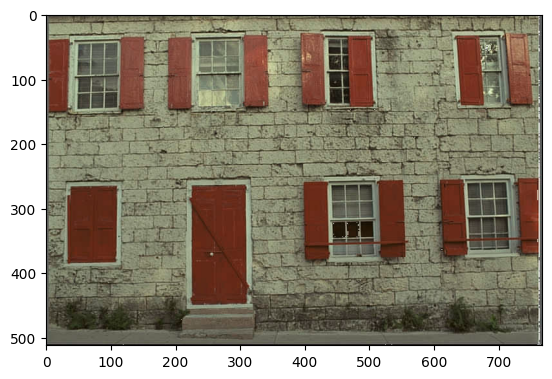

In [102]:
print(rm, ps, cr)
plt.imshow(decodedImg.astype(np.uint8))

## LZW Encoding

In [258]:
def find_entropy(gray):
    pixel_values = gray.flatten()
    hist, _ = np.histogram(pixel_values, bins=256)
    probabilities = hist / np.sum(hist)
    probabilities += 1e-10
    probabilities /= np.sum(probabilities)
    entropy = -np.sum(probabilities * np.log2(probabilities))
        
    return  entropy

In [259]:
def LZWEncoder(arr, blockSize, codeSize):   
    dictionary = OrderedDict()
    dictionary = {str(i): [0, i] for i in range(256)}
    encoding = []
    curr = ''
    prev = ''
    cntr = 256
    for i in range(blockSize):
        for j in range(blockSize):
            if(i == 0 and j == 0):
                prev = str(arr[i,j])
                continue
            
            curr = str(arr[i, j])
            
            if((prev + '-' + curr) in dictionary): # present in dict
                prev = prev + '-' + curr
            else: 
                # not present in dict
                encoded = 0
                if(len(prev.split('-')) == 1):
                    encoded = int(prev)
                else:
                    encoded = dictionary[prev][1]
                
                encoding.append(encoded)
                if(cntr <= 2**codesize):
                    dictionary[prev + '-' + curr] = [encoded, cntr]
                    cntr += 1                
                
                prev = curr
                
    
    encoding.append(dictionary[prev][1])
    
    return encoding

In [335]:
def enLZW(filename, blockSize, cs):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = addPadding(img, blockSize, 1).astype(np.uint8)
    
    h, w = img.shape
    numOfCodes = 0
    maxEncodeVal = 0

    if(blockSize == -1):
        blockSize = min(h, w)

    encodings = []
    temp = []
    entropies = []
    avg = 0

    for i in range(0, h, blockSize):
        for j in range(0, w, blockSize):
            arr = img[i : i + blockSize, j : j + blockSize]
            entropies.append(find_entropy(arr))

            # get LZW encoding
            encoding = LZWEncoder(arr, blockSize, cs)
            
            avg += ((len(encoding) * cs) / (blockSize * blockSize))
            numOfCodes += len(encoding)
            temp.extend(encoding)
            maxEncodeVal = max(maxEncodeVal, max(encoding))
            encodings.append(encoding)

    with open("img1_lzwcode.txt", "w") as f:
        f.write(f"{h} {w} {blockSize}\n")
        for en in encodings:
            s = [str(i) for i in en]
            string = " ".join(s)
            f.write(string)
            f.write("\n")
    
    print("LZW encoding text file has been generated")
    
    uniqueCodes = len(set(temp))
    numBlocks = (h * w) // (blockSize * blockSize)
    
    avgLen = avg / numBlocks
    compRatio = (h * w * 8) / (numOfCodes * cs)
    entropy = sum(entropies) / len(entropies)
    
    return (numOfCodes, maxEncodeVal, avgLen, compRatio, entropy)

In [336]:
# change parameters here
blockSize = 600
codeSize = 10
filename = "Images/matches-aligned.tif" 

numOfCodes, maxEncodeVal, avgLen, compRatio, entropy = enLZW(filename, blockSize, codeSize)

LZW encoding text file has been generated


In [337]:
print(numOfCodes, maxEncodeVal, avgLen, compRatio, entropy)

311795 1024 8.660972222222222 0.923683830722109 7.346316446786117


## LZW Decoding

In [338]:
def decodeLZW(bs, encoding, codeSize):
    h, w = bs, bs
    dictionary = {i: [i] for i in range(256)} # initialize dictionary with single-element lists
    next_code = 256 # next available code
    decodedImg = [] # decoded output
    prev = [encoding[0]] # initialize prefix
    decodedImg.extend(prev) # output first element of prefix
 
    for i in range(1, len(encoding)):
        code = encoding[i]
        if code not in dictionary:
            entry = prev + [prev[0]]
        else:
            entry = dictionary[code]
        decodedImg.extend(entry)
        
        if(next_code <= 2**codeSize):
            dictionary[next_code] = prev + [entry[0]]
            next_code += 1
                    
        prev = entry

    # convert the decoded output to a 2D array of pixel values
    pixels = np.array(decodedImg).reshape(h, w)
    return pixels

In [339]:
def deLZW(codedFilename, codeSize):
    h, w, blockSize = 0, 0, 0
    encoding = []

    with open(codedFilename, "r") as f:
        first_line = f.readline().strip()
        values = first_line.split()
        h = int(values[0])
        w = int(values[1])
        blockSize = int(values[2])

        for line in f:
            line = line.strip()
            values = line.split(" ")
            values = [int(i) for i in values]
            encoding.append(values)
    reconstructedImg = np.zeros((h, w))
    i, j = 0, 0
    arr = []
    for en in encoding:
        arr = decodeLZW(blockSize, en, codeSize)
        
        reconstructedImg[i : i + blockSize, j : j + blockSize] = arr
        if(j + blockSize >= w):
            i += blockSize
            j = 0
        else:
            j += blockSize
    
    return reconstructedImg

In [340]:
filename = "img1_lzwcode.txt"
codesize = 10
reconstructedImg = deLZW(filename, codesize)

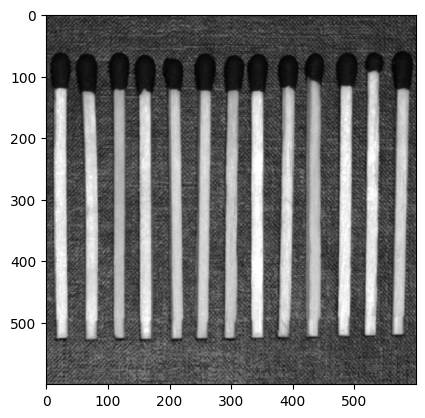

In [341]:
plt.imshow(reconstructedImg, cmap = 'gray')

In [342]:
im = cv2.imread("Images/matches-aligned.tif")
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im = addPadding(im, blockSize, 1).astype(np.uint8)
rmse(im, reconstructedImg)

0.0